In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime
import networkx as nx

In [76]:
reviews = pd.read_csv('./reviews.csv', parse_dates=['timestamp'])

# Overview

In [77]:
persons = set(reviews.author) | set(reviews.reviewer)

persons_PF = set(reviews[reviews.orgunit == 'Platform'].reviewer.values) | set(reviews[reviews.orgunit == 'Platform'].author.values)
persons_PL = set(reviews[reviews.orgunit == 'ProductLine'].reviewer.values) | set(reviews[reviews.orgunit == 'ProductLine'].author.values)

persons_PFPL = persons_PF & persons_PL
persons_PL_only = persons_PL - persons_PF
persons_PF_only = persons_PF - persons_PL

len(persons), len(persons_PFPL), len(persons_PL_only), len(persons_PF_only)

(962, 81, 485, 396)

In [78]:
reviews.timestamp.min(), reviews.timestamp.max()

(Timestamp('2012-03-07 07:33:05'), Timestamp('2017-02-28 18:46:57.107000'))

In [80]:
reviews.id.nunique()

13297

In [81]:
reviews.file.nunique()

206174

# Code overload

In [82]:
review_size = reviews[['id', 'file']].groupby('id').file.nunique()

In [83]:
review_size.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    13297.000000
mean        33.879446
std        754.907043
min          1.000000
1%           1.000000
10%          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
90%         20.000000
99%        317.240000
max      50893.000000
Name: file, dtype: float64

# Feedback overload

In [88]:
feedback_size = reviews[['id', 'reviewer']].groupby('id').reviewer.nunique()

In [89]:
feedback_size.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    13297.000000
mean         3.356547
std          7.883280
min          1.000000
1%           2.000000
10%          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
90%          5.000000
99%         19.000000
max        272.000000
Name: reviewer, dtype: float64

# Irregular review

In [115]:
time_between_reviews = reviews[['reviewer', 'id', 'timestamp']].drop_duplicates().groupby('reviewer').apply(lambda df: df.timestamp.drop_duplicates().sort_values().diff()).dropna().reset_index(drop=True)

In [116]:
time_between_reviews.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count                          64599
mean      10 days 16:25:31.887315995
std       37 days 00:56:08.051041856
min           0 days 00:00:00.394000
1%                   0 days 00:00:14
10%           0 days 00:07:03.623400
25%           0 days 02:56:34.370000
50%           1 days 22:34:40.933000
75%           7 days 04:26:34.790000
90%       22 days 09:13:26.325800012
95%                 42 days 00:00:00
99%      150 days 21:56:12.091859906
max        1468 days 03:51:11.303000
Name: timestamp, dtype: object

# Untapped potential & tapped unpotential

In [121]:
reviewers_not_authoring = set(reviews.reviewer) - set(reviews.author)
len(reviewers_not_authoring), len(reviewers_not_authoring)/len(persons)

(358, 0.37214137214137216)

In [117]:
authors_not_reviewing = set(reviews.author) - set(reviews.reviewer)
len(authors_not_reviewing), len(authors_not_reviewing)/len(persons)

(15, 0.015592515592515593)

In [122]:
reviews[reviews.reviewer.isin(reviewers_not_authoring)].id.nunique()

1539

In [123]:
reviews[reviews.reviewer.isin(reviewers_not_authoring)].file.nunique()/reviews.file.nunique()

0.28106841793824633

In [124]:
drive_by_reviews = reviews[['reviewer', 'id']].drop_duplicates().groupby('reviewer').id.nunique()
drive_by_reviews[drive_by_reviews==1].shape[0]

41

In [125]:
drive_by_contributions = reviews[['author', 'id']].drop_duplicates().groupby('author').id.nunique()
drive_by_contributions[drive_by_contributions==1].shape[0]

81

In [192]:
review_code_ratio = pd.concat([
    reviews.groupby('reviewer').id.nunique().rename('Reviews'), 
    reviews.groupby('author').id.nunique().rename('Code contributions')], axis=1, sort=False).fillna(0)

review_code_ratio.describe(percentiles=[0.5, 0.9, 0.95])

,Reviews,Code contributions
count,962.000000,962.000000
mean,46.395010,13.824324
std,59.072998,30.157155
min,0.000000,0.000000
50%,26.000000,3.000000
90%,109.000000,36.000000
95%,156.950000,63.000000
max,463.000000,290.000000


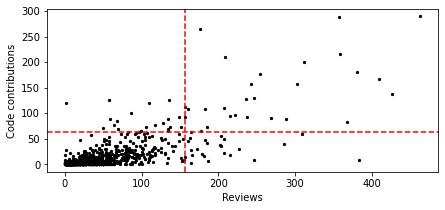

In [200]:
fig, ax = plt.subplots(figsize=(7, 3));

review_code_ratio.plot.scatter(x='Reviews', y='Code contributions', marker='.', color='black', ax=ax)
ax.axvline(156, linestyle='dashed', color='red')
ax.axhline(63, linestyle='dashed', color='red')

fig.savefig('./ratio.pgf', dpi=600, bbox_inches='tight')

# Information bottleneck

In [330]:
edgelist = reviews[['author', 'reviewer', 'id']].groupby(['author', 'reviewer']).id.nunique().reset_index()
edgelist.rename(columns={'author': 'source', 'reviewer': 'target', 'id': 'weight'}, inplace=True)

In [332]:
G = nx.MultiGraph(edgelist)

connected = list(nx.connected_components(G))[0]
G_connected = G.subgraph(connected)
degrees = G_connected.degree()

In [337]:
pos = nx.spring_layout(G_connected) 

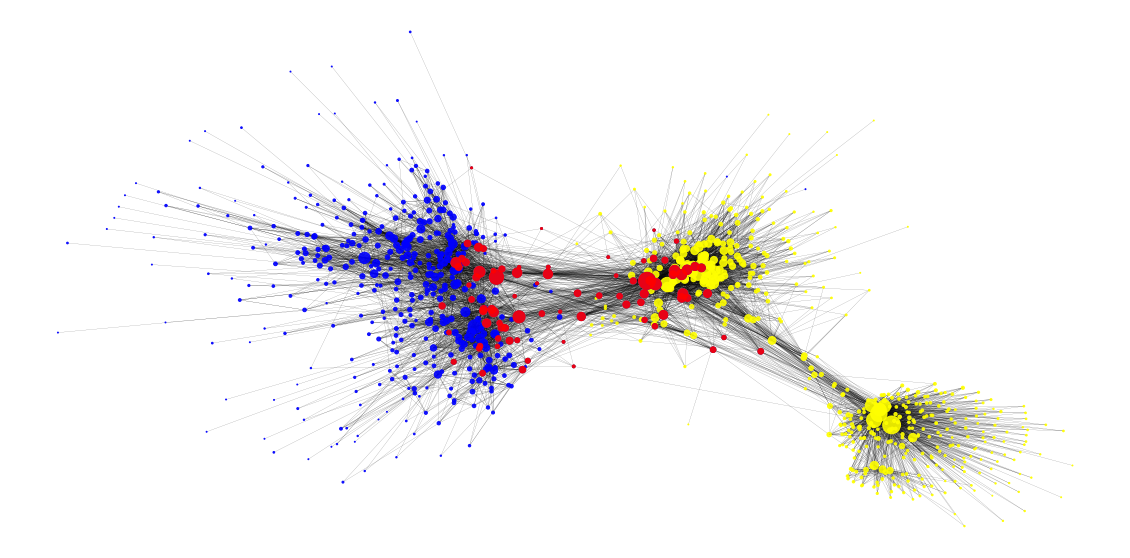

In [338]:
fig, ax = plt.subplots(figsize=(20, 10));

# nodes
nx.draw_networkx_nodes(G_connected, pos,
                       nodelist=persons_PL & connected,
                       node_color='yellow',
                       node_size=[degrees[p] for p in persons_PL & connected],
                       alpha=0.9,
                       ax=ax)
nx.draw_networkx_nodes(G_connected, pos,
                       nodelist=persons_PF & connected,
                       node_color='blue',
                       node_size=[degrees[p] for p in persons_PF & connected],
                       alpha=0.9,
                       ax=ax)
nx.draw_networkx_nodes(G_connected, pos,
                       nodelist=persons_PFPL & connected,
                       node_color='red',
                       node_size=[degrees[p] for p in persons_PFPL & connected],
                       alpha=0.9,
                       ax=ax)

# edges
nx.draw_networkx_edges(G_connected, pos, width=0.1, ax=ax)
plt.box(False)
fig.savefig('./network.png', dpi=300)